In [25]:
#pip install geopy

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [27]:
#print("="*70)
#print("STEP 1: LOADING DATA")
#print("="*70)
data_path = r"C:/Users/PC/Desktop/AIMS-DSCBI_James/dT to use/gisny_use.csv"
df = pd.read_csv(data_path, parse_dates=['timestamp'])
#print(f"Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Shape: (6999, 7)

Columns: ['timestamp', 'StationName', 'Rain(mm)', 'temperature', 'Humidity', 'wind_speed', 'wind_dir']

First few rows:
            timestamp StationName  Rain(mm)  temperature  Humidity  \
0 2025-05-14 07:00:00     Gisenyi       0.0         25.8        65   
1 2025-05-14 07:30:00     Gisenyi       0.0         27.0         0   
2 2025-05-14 08:20:00     Gisenyi       0.0         23.1        62   
3 2025-05-14 12:50:00     Gisenyi       0.0         23.7        12   
4 2025-05-14 13:00:00     Gisenyi       0.0         23.8        11   

   wind_speed  wind_dir  
0         1.5       228  
1         3.3       227  
2         3.4       204  
3         3.1       198  
4         1.8       198  

Data types:
timestamp      datetime64[ns]
StationName            object
Rain(mm)              float64
temperature           float64
Humidity                int64
wind_speed            float64
wind_dir                int64
dtype: object


In [28]:
column_mapping = {}
for col in df.columns:
    col_lower = col.lower()
    if 'rain' in col_lower:
        column_mapping[col] = 'rainfall'
    elif 'temp' in col_lower:
        column_mapping[col] = 'temperature'
    elif 'humid' in col_lower or 'hum' in col_lower:
        column_mapping[col] = 'humidity'
    elif 'wind' in col_lower and 'speed' in col_lower:
        column_mapping[col] = 'wind_speed'
    elif 'wind' in col_lower and 'dir' in col_lower:
        column_mapping[col] = 'wind_dir'
    elif 'station' in col_lower:
        column_mapping[col] = 'station_id'

df = df.rename(columns=column_mapping)
print(f"Standardized columns: {df.columns.tolist()}")

Standardized columns: ['timestamp', 'station_id', 'rainfall', 'temperature', 'humidity', 'wind_speed', 'wind_dir']


In [29]:
def preliminary_qc(df):
    """
    Performs initial quality control:
    1. Range checks
    2. Repeating value detection
    3. Rolling mean imputation
    """
    df = df.copy()
    
    # Define physically plausible limits
    limits = {
        'rainfall': (0, 30),        # mm (adjusted upper limit)
        'temperature': (5, 45),      # °C
        'humidity': (10, 100),       # %
        'wind_speed': (0, 50),       # m/s (adjusted)
        'wind_dir': (0, 360)         # degrees
    }
    # Initialize summary
    summary = {col: {'outliers': 0, 'repeats': 0, 'missing_replaced': 0} 
               for col in limits.keys() if col in df.columns} 
    # Step 1: Range checks
    print("\nApplying range checks...")
    for col, (low, high) in limits.items():
        if col in df.columns:
            outlier_mask = (df[col] < low) | (df[col] > high)
            summary[col]['outliers'] = outlier_mask.sum()
            df.loc[outlier_mask, col] = np.nan
            print(f"  {col}: {summary[col]['outliers']} values outside [{low}, {high}]")
    
    # Step 2: Detect repeating values (3+ consecutive identical values)
    print("\nDetecting repeating values...")
    for col in limits.keys():
        if col in df.columns:
            # Check if current value equals previous 2 values
            repeat_mask = (
                (df[col] == df[col].shift(1)) & 
                (df[col] == df[col].shift(2))
            )
            summary[col]['repeats'] = repeat_mask.sum()
            df.loc[repeat_mask, col] = np.nan
            print(f"  {col}: {summary[col]['repeats']} repeating values detected")
    
    # Step 3: Impute missing values with rolling mean
    print("\nImputing missing values with 10-record rolling mean...")
    window = 10
    for col in ['temperature', 'humidity', 'wind_speed', 'wind_dir']:
        if col in df.columns:
            missing_before = df[col].isna().sum()
            rolling_mean = df[col].rolling(window, min_periods=1, center=True).mean()
            df[col] = df[col].fillna(rolling_mean)
            missing_after = df[col].isna().sum()
            summary[col]['missing_replaced'] = missing_before - missing_after
            print(f"  {col}: {summary[col]['missing_replaced']} values imputed")
    
    # rainfall (use 0 or special value)
    if 'rainfall' in df.columns:
        rain_missing = df['rainfall'].isna().sum()
        df['rainfall'] = df['rainfall'].fillna(0)  # Assume no rain if missing
        summary['rainfall']['missing_replaced'] = rain_missing
        print(f"  rainfall: {rain_missing} missing values set to 0")
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary).T
    
    return df, summary_df

df_qc, qc_summary = preliminary_qc(df)

print("\n" + "-"*70)
print("QUALITY CONTROL SUMMARY")
print("-"*70)
print(qc_summary)


Applying range checks...
  rainfall: 0 values outside [0, 30]
  temperature: 0 values outside [5, 45]
  humidity: 19 values outside [10, 100]
  wind_speed: 0 values outside [0, 50]
  wind_dir: 0 values outside [0, 360]

Detecting repeating values...
  rainfall: 6249 repeating values detected
  temperature: 126 repeating values detected
  humidity: 6830 repeating values detected
  wind_speed: 64 repeating values detected
  wind_dir: 5 repeating values detected

Imputing missing values with 10-record rolling mean...
  temperature: 774 values imputed
  humidity: 53 values imputed
  wind_speed: 64 values imputed
  wind_dir: 5 values imputed
  rainfall: 6445 missing values set to 0

----------------------------------------------------------------------
QUALITY CONTROL SUMMARY
----------------------------------------------------------------------
             outliers  repeats  missing_replaced
rainfall            0     6249              6445
temperature         0      126               774

In [30]:
feature_cols = ['rainfall', 'temperature', 'humidity', 'wind_speed', 'wind_dir']
available_features = [col for col in feature_cols if col in df_qc.columns]

if len(available_features) >= 2:
    # Remove any remaining NaN values for Isolation Forest
    df_for_iso = df_qc[available_features].dropna()
    indices = df_for_iso.index
    
    iso = IsolationForest(
        n_estimators=200, 
        contamination=0.02,  # Expect 2% outliers
        random_state=42
    )
    
    predictions = iso.fit_predict(df_for_iso)
    
    # Map back to original dataframe
    df_qc['iso_outlier'] = False
    df_qc.loc[indices, 'iso_outlier'] = (predictions == -1)
    
    print(f"Isolation Forest outliers detected: {df_qc['iso_outlier'].sum()}")
else:
    print("Not enough features for Isolation Forest")
    df_qc['iso_outlier'] = False

Isolation Forest outliers detected: 4


In [31]:
if 'station_id' in df_qc.columns:
    df_qc = df_qc.sort_values(['station_id', 'timestamp']).reset_index(drop=True)
else:
    df_qc = df_qc.sort_values('timestamp').reset_index(drop=True)

# Define maximum acceptable changes between consecutive readings
max_changes = {
    'rainfall': 50,       # mm in 10 minutes
    'temperature': 5,     # °C in 10 minutes
    'humidity': 20,       # % in 10 minutes
    'wind_speed': 10,     # m/s in 10 minutes
    'wind_dir': 180       # degrees in 10 minutes
}

print("Detecting abrupt temporal changes...")
for col, max_change in max_changes.items():
    if col in df_qc.columns:
        # Calculate absolute difference from previous reading
        if 'station_id' in df_qc.columns:
            df_qc[f'{col}_diff'] = df_qc.groupby('station_id')[col].diff().abs()
        else:
            df_qc[f'{col}_diff'] = df_qc[col].diff().abs()
        
        df_qc[f'{col}_temporal_outlier'] = df_qc[f'{col}_diff'] > max_change
        
        n_outliers = df_qc[f'{col}_temporal_outlier'].sum()
        print(f"  {col}: {n_outliers} temporal outliers (change > {max_change})")

Detecting abrupt temporal changes...
  rainfall: 0 temporal outliers (change > 50)
  temperature: 2 temporal outliers (change > 5)
  humidity: 13 temporal outliers (change > 20)
  wind_speed: 0 temporal outliers (change > 10)
  wind_dir: 376 temporal outliers (change > 180)


In [32]:
def detect_statistical_outliers(df, col, z_threshold=3, iqr_multiplier=1.5):
    """Detect outliers using both Z-score and IQR methods"""
    if col not in df.columns:
        return pd.Series(False, index=df.index)
    
    data = df[col].dropna()
    
    # Z-score method
    mean = data.mean()
    std = data.std()
    z_scores = np.abs((df[col] - mean) / std)
    z_outliers = z_scores > z_threshold
    
    # IQR method
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    iqr_outliers = (df[col] < (q1 - iqr_multiplier * iqr)) | \
                   (df[col] > (q3 + iqr_multiplier * iqr))
    
    # Combined: flag if detected by either method
    combined_outliers = z_outliers | iqr_outliers
    
    return combined_outliers

for col in ['temperature', 'humidity', 'wind_speed', 'wind_dir', 'rainfall']:
    if col in df_qc.columns:
        df_qc[f'{col}_stat_outlier'] = detect_statistical_outliers(df_qc, col)
        n_outliers = df_qc[f'{col}_stat_outlier'].sum()
        print(f"{col}: {n_outliers} statistical outliers detected")


temperature: 0 statistical outliers detected
humidity: 0 statistical outliers detected
wind_speed: 378 statistical outliers detected
wind_dir: 0 statistical outliers detected
rainfall: 151 statistical outliers detected


In [33]:
# Create master outlier flags for each variable
for col in ['temperature', 'humidity', 'wind_speed', 'wind_dir', 'rainfall']:
    if col in df_qc.columns:
        temporal_col = f'{col}_temporal_outlier'
        stat_col = f'{col}_stat_outlier'
        
        # Combine temporal and statistical flags
        df_qc[f'{col}_outlier'] = False
        
        if temporal_col in df_qc.columns:
            df_qc[f'{col}_outlier'] |= df_qc[temporal_col]
        
        if stat_col in df_qc.columns:
            df_qc[f'{col}_outlier'] |= df_qc[stat_col]
        
        # Add Isolation Forest flag
        df_qc[f'{col}_outlier'] |= df_qc['iso_outlier']
        
        total = df_qc[f'{col}_outlier'].sum()
        pct = (total / len(df_qc)) * 100
        print(f"{col}: {total} total outliers ({pct:.2f}%)")

temperature: 6 total outliers (0.09%)
humidity: 15 total outliers (0.21%)
wind_speed: 382 total outliers (5.46%)
wind_dir: 378 total outliers (5.40%)
rainfall: 154 total outliers (2.20%)


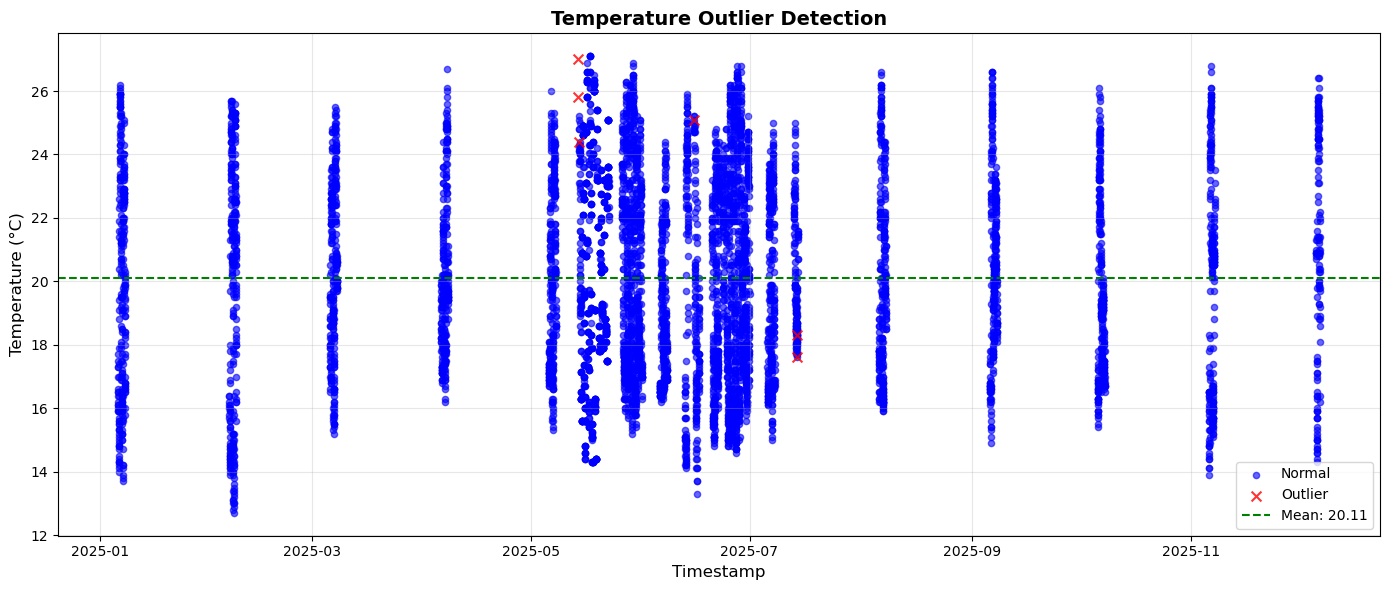

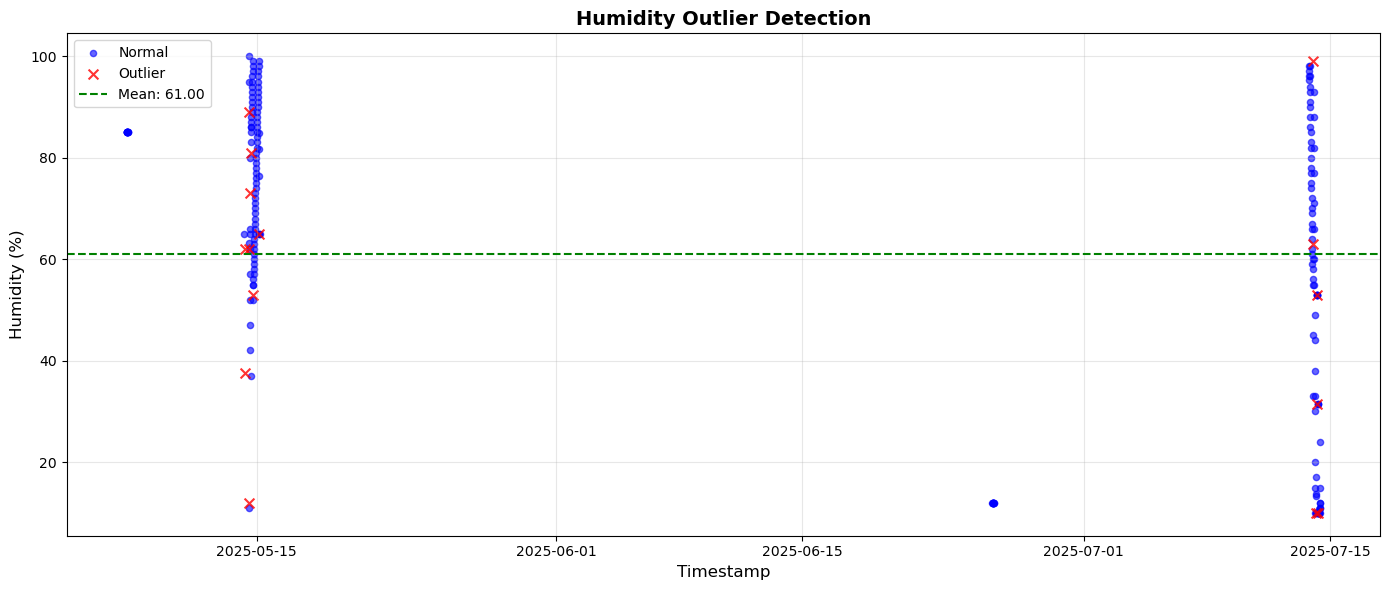

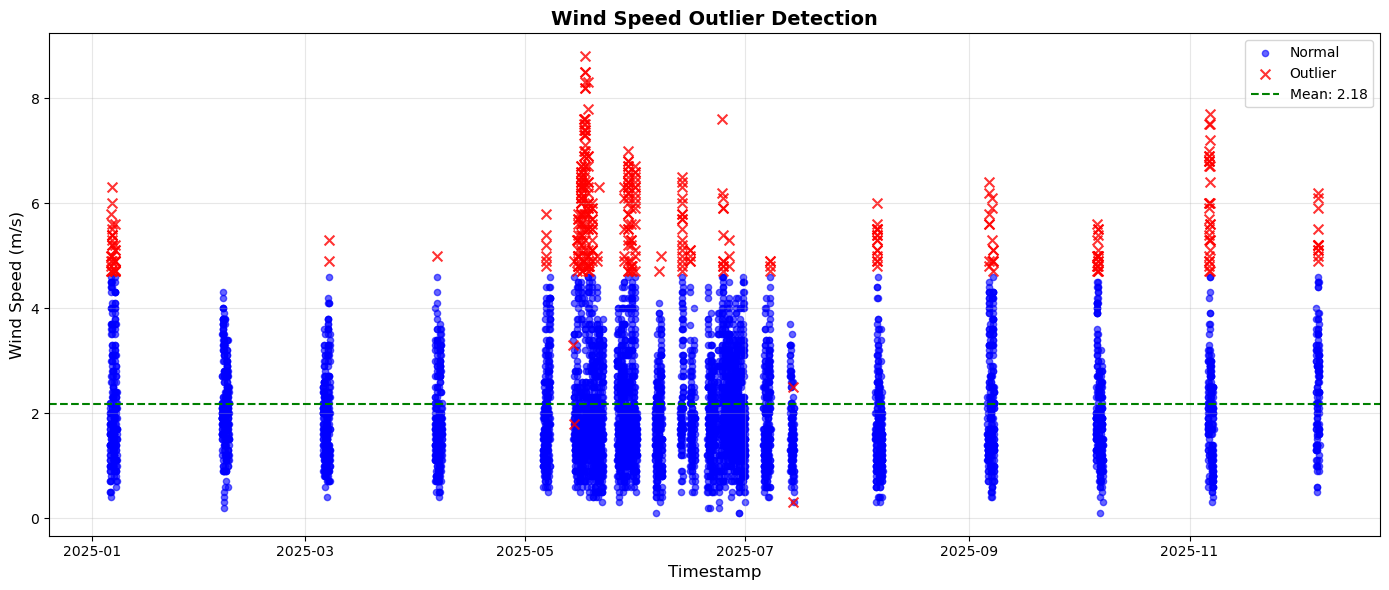

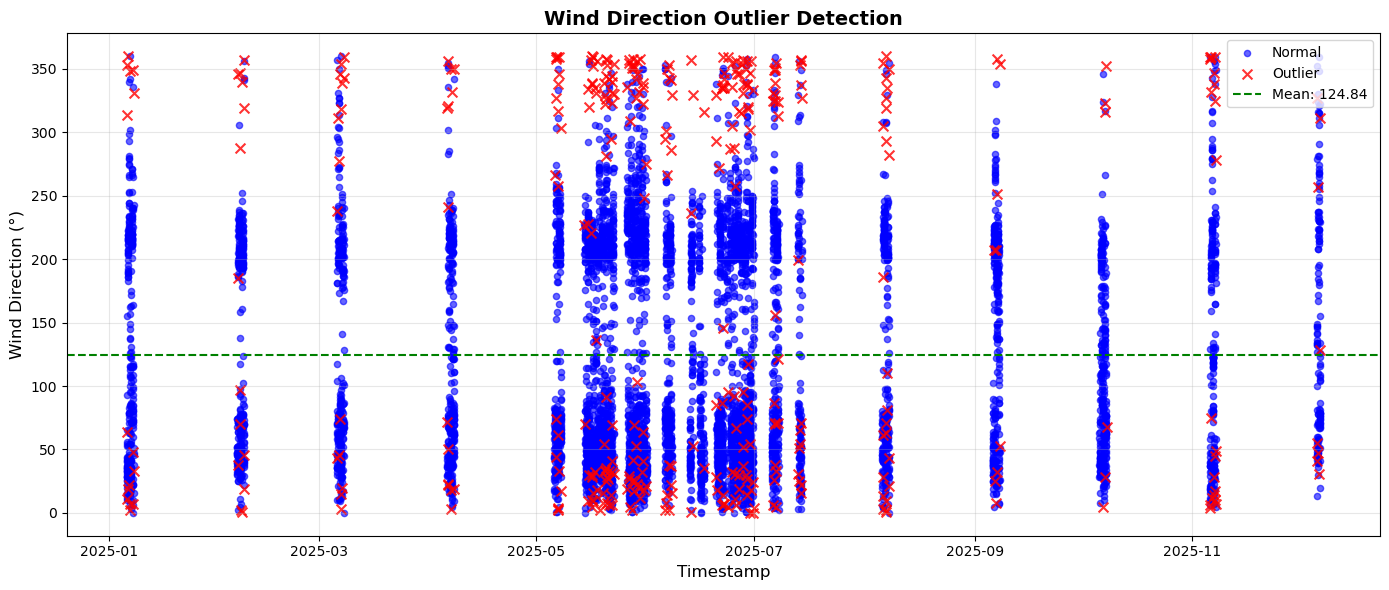

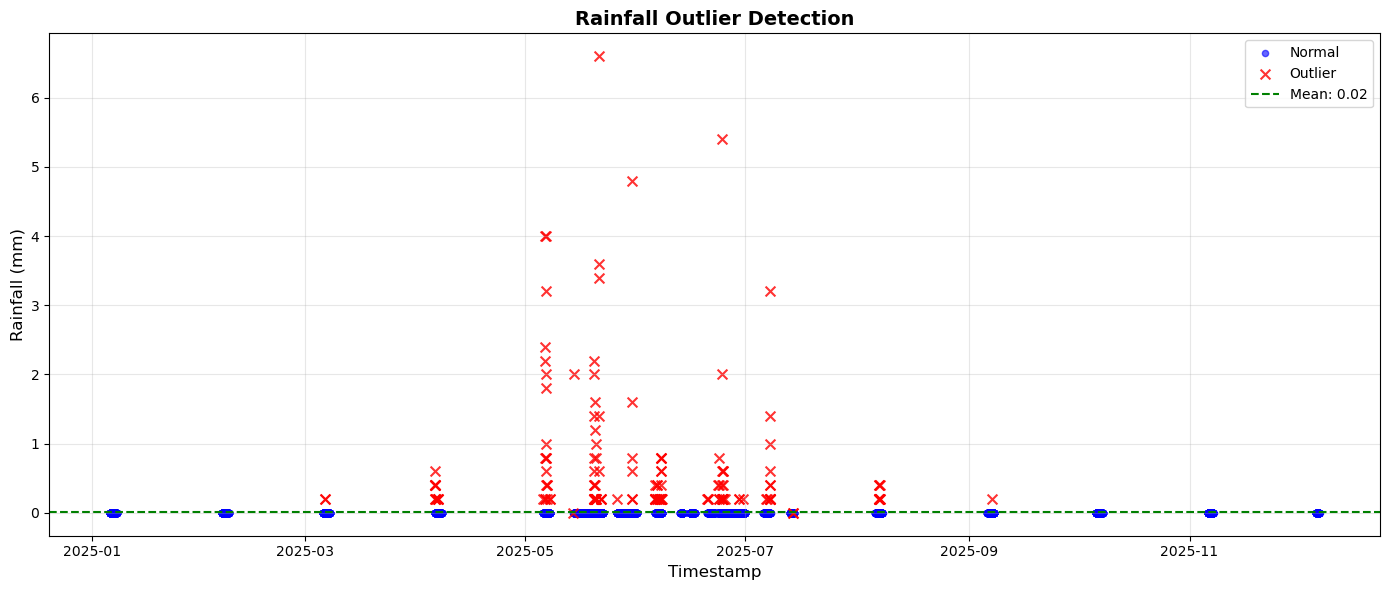

In [34]:
def plot_outliers(df, col, outlier_col, ylabel, title):
    """Create scatter plot showing outliers"""
    if col not in df.columns or outlier_col not in df.columns:
        print(f"Skipping plot for {col} - column not found")
        return
    
    plt.figure(figsize=(14, 6))
    
    # Plot normal points
    normal = df[~df[outlier_col]]
    plt.scatter(normal['timestamp'], normal[col], 
                c='blue', s=20, alpha=0.6, label='Normal')
    
    # Plot outliers
    outliers = df[df[outlier_col]]
    if len(outliers) > 0:
        plt.scatter(outliers['timestamp'], outliers[col], 
                    c='red', s=50, alpha=0.8, label='Outlier', marker='x')
    
    # Add mean line
    mean_val = df[col].mean()
    plt.axhline(mean_val, color='green', linestyle='--', 
                linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot each variable
plot_configs = [
    ('temperature', 'temperature_outlier', 'Temperature (°C)', 'Temperature Outlier Detection'),
    ('humidity', 'humidity_outlier', 'Humidity (%)', 'Humidity Outlier Detection'),
    ('wind_speed', 'wind_speed_outlier', 'Wind Speed (m/s)', 'Wind Speed Outlier Detection'),
    ('wind_dir', 'wind_dir_outlier', 'Wind Direction (°)', 'Wind Direction Outlier Detection'),
    ('rainfall', 'rainfall_outlier', 'Rainfall (mm)', 'Rainfall Outlier Detection')
]

for col, outlier_col, ylabel, title in plot_configs:
    plot_outliers(df_qc, col, outlier_col, ylabel, title)

In [35]:
# Filter out records flagged as outliers in ANY variable
outlier_columns = [f'{col}_outlier' for col in 
                   ['temperature', 'humidity', 'wind_speed', 'wind_dir', 'rainfall']
                   if f'{col}_outlier' in df_qc.columns]

# Create mask for clean data (no outliers)
clean_mask = ~df_qc[outlier_columns].any(axis=1)
df_clean = df_qc[clean_mask].copy()

print(f"Original dataset size: {len(df_qc)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Records removed: {len(df_qc) - len(df_clean)} ({((len(df_qc) - len(df_clean))/len(df_qc)*100):.2f}%)")

Original dataset size: 6999
Clean dataset size: 6106
Records removed: 893 (12.76%)


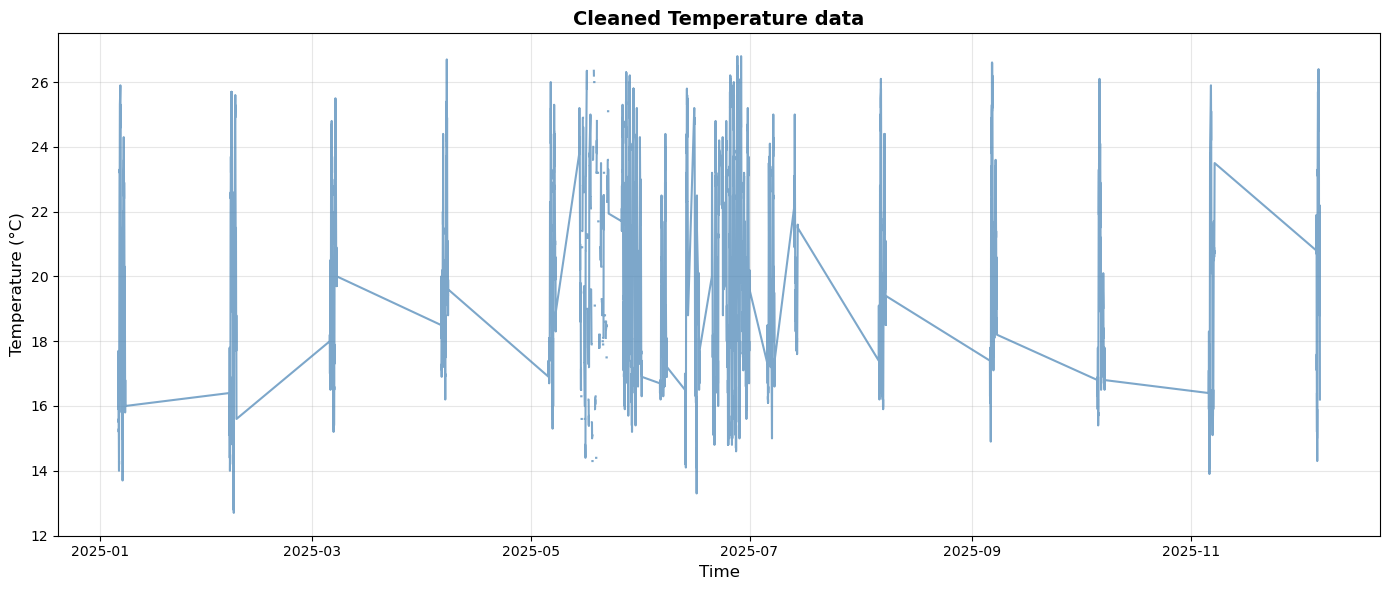

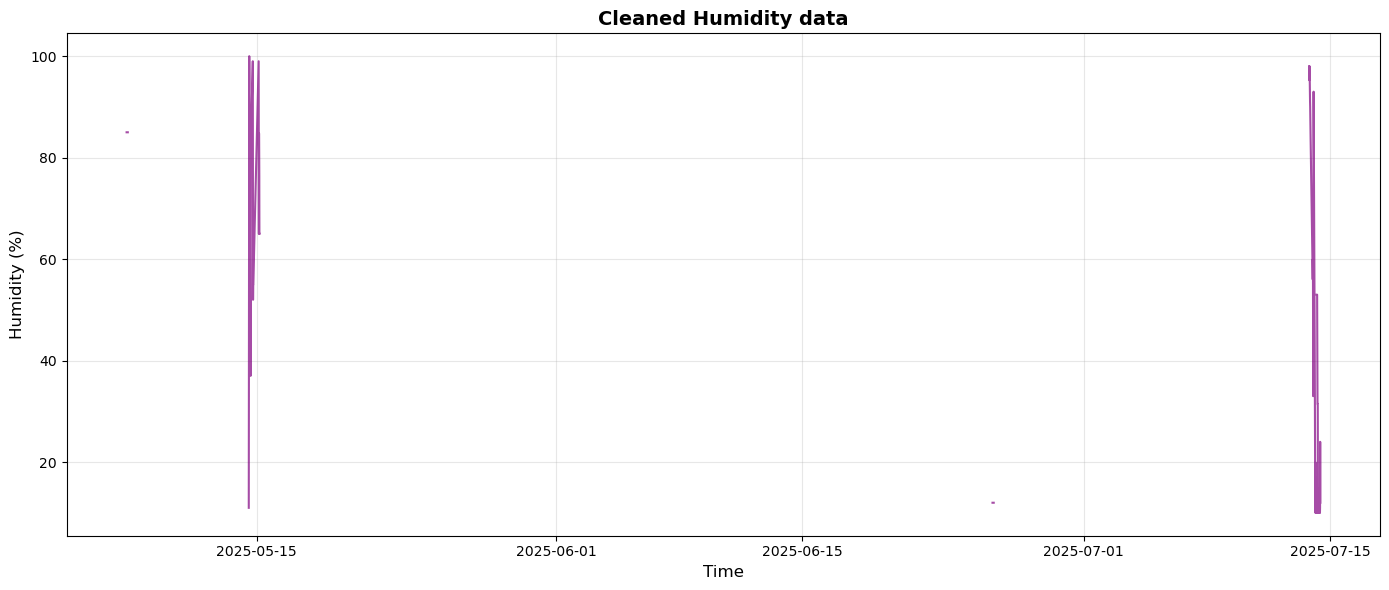

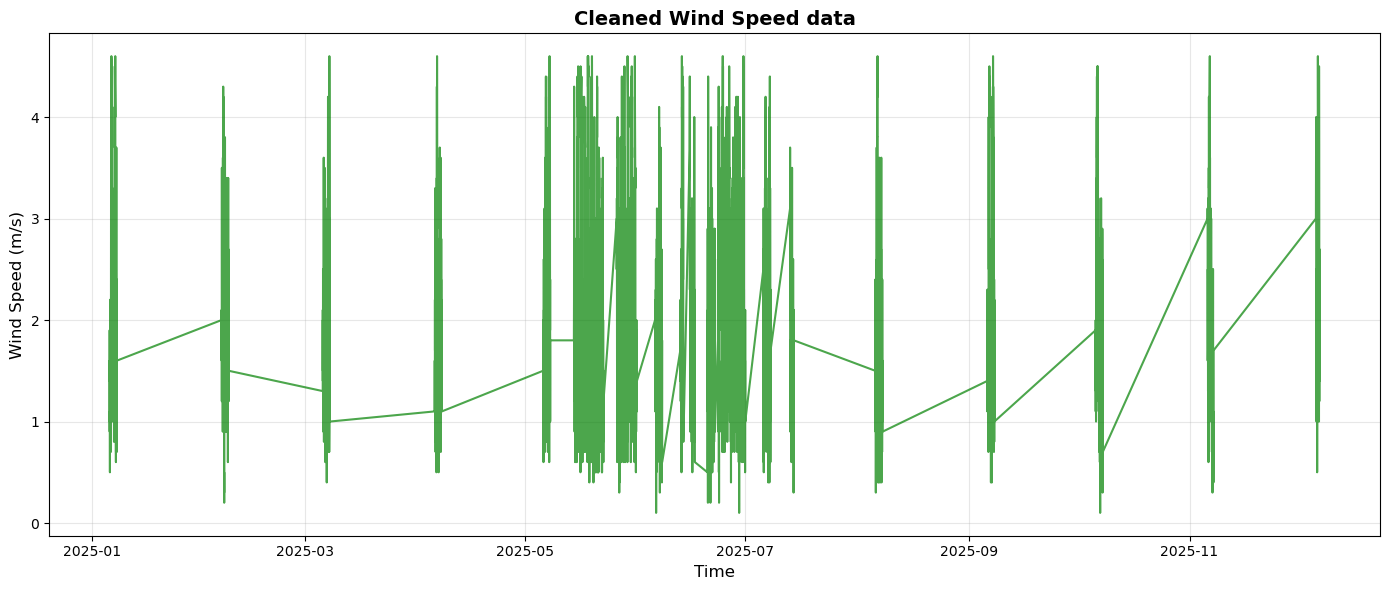

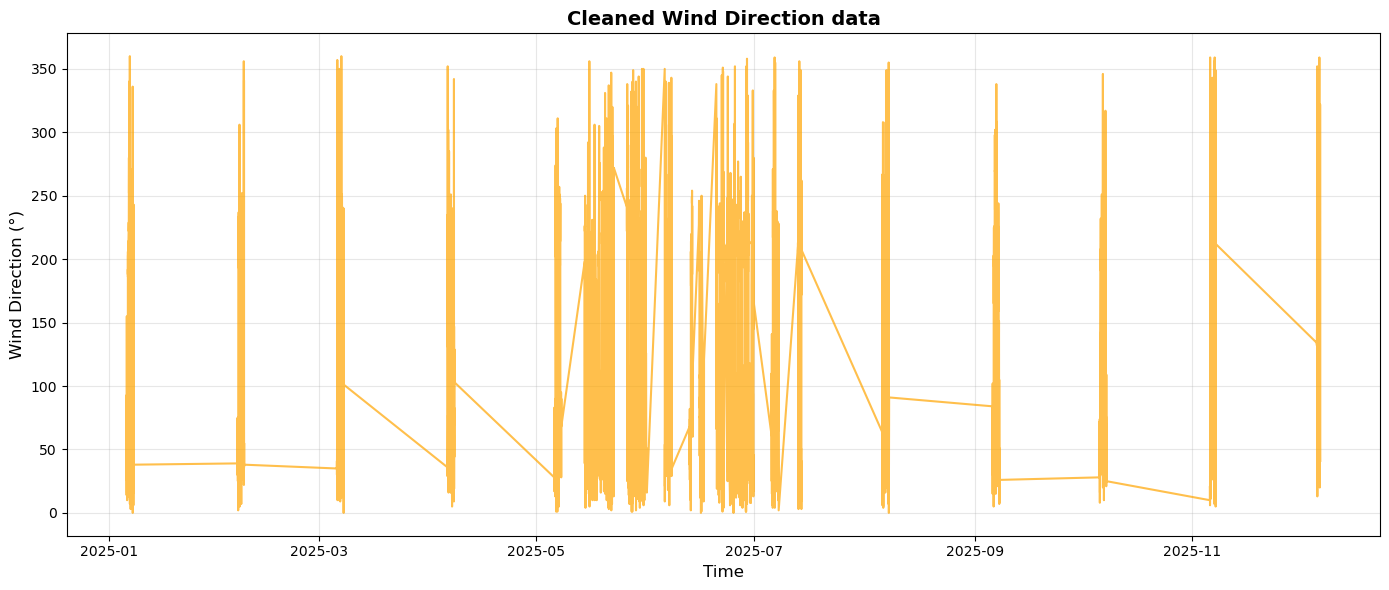

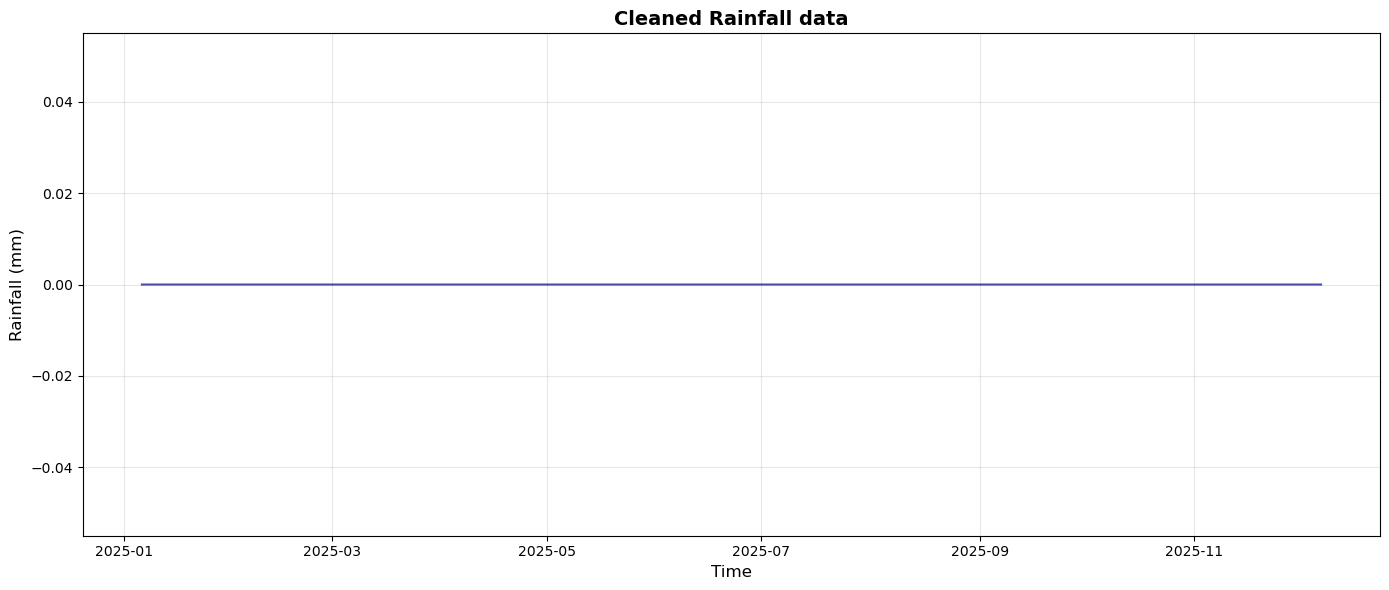

In [36]:
def plot_cleaned_timeseries(df, col, ylabel, title, color):
    """Plot cleaned time series data"""
    if col not in df.columns:
        print(f"Skipping plot for {col} - column not found")
        return
    
    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df[col], color=color, linewidth=1.5, alpha=0.7)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot cleaned data
clean_configs = [
    ('temperature', 'Temperature (°C)', 'Cleaned Temperature data', 'steelblue'),
    ('humidity', 'Humidity (%)', 'Cleaned Humidity data', 'purple'),
    ('wind_speed', 'Wind Speed (m/s)', 'Cleaned Wind Speed data', 'green'),
    ('wind_dir', 'Wind Direction (°)', 'Cleaned Wind Direction data', 'orange'),
    ('rainfall', 'Rainfall (mm)', 'Cleaned Rainfall data', 'darkblue')
]

for col, ylabel, title, color in clean_configs:
    plot_cleaned_timeseries(df_clean, col, ylabel, title, color)

In [37]:
# Save QC'd data with flags
output_path_qc = r"C:/Users/PC/Desktop/AIMS-DSCBI_James/dT to use/data_with_qc_flags.csv"
df_qc.to_csv(output_path_qc, index=False)
print(f"✓ QC data with flags saved to: {output_path_qc}")

# Save clean data
output_path_clean = r"C:/Users/PC/Desktop/AIMS-DSCBI_James/dT to use/cleaned_data_final.csv"
df_clean.to_csv(output_path_clean, index=False)
print(f"✓ Clean data saved to: {output_path_clean}")

✓ QC data with flags saved to: C:/Users/PC/Desktop/AIMS-DSCBI_James/dT to use/data_with_qc_flags.csv
✓ Clean data saved to: C:/Users/PC/Desktop/AIMS-DSCBI_James/dT to use/cleaned_data_final.csv


In [38]:
summary_cols = ['temperature', 'humidity', 'wind_speed', 'wind_dir', 'rainfall']
available_cols = [col for col in summary_cols if col in df_clean.columns]

if available_cols:
    print("\nCleaned Data Summary:")
    print(df_clean[available_cols].describe())

print("\n" + "="*70)
print("QUALITY CONTROL PROCESS COMPLETED SUCCESSFULLY!")
print("="*70)


Cleaned Data Summary:
       temperature    humidity   wind_speed     wind_dir  rainfall
count  5805.000000  179.000000  6106.000000  6106.000000    6106.0
mean     19.947679   62.538787     2.013361   116.628471       0.0
std       3.099877   29.273209     0.899529    86.847602       0.0
min      12.700000   10.000000     0.100000     0.000000       0.0
25%      17.400000   46.000000     1.400000    44.000000       0.0
50%      19.700000   69.000000     1.800000    76.000000       0.0
75%      22.600000   85.500000     2.600000   204.000000       0.0
max      26.800000  100.000000     4.600000   360.000000       0.0

QUALITY CONTROL PROCESS COMPLETED SUCCESSFULLY!
